# Data Mining and Machine Learning Assignment 1: Data Analytics

## Introduction

This notebook includes three real-world examples prepared for the first assignment of summer Machine Learning course. Each example shows how machine learning can be used to understand user behavior in different areas:

- Smart Home/IoT: analyzing household power consumption data collected over 47 months in France to identify usage patterns and how machine learning can model daily routines for more efficient energy use in homes

- Entertainment/Streaming: using Spotify listening history to find similar tracks and illustrate personalized music recommendations with machine learning

- Gaming/Esports: recommending new Steam games to users based on playtime patterns of similar players, showcasing collaborative filtering techniques

In each case, we process the data, apply a basic machine learning technique, and present a clear visualization of the result.

## Smart Home / Internet of Things (IoT)
### About the dataset:
This dataset contains over 47 months of minute-level power usage from a single household in France. It records the electricity consumption of three sub-meters (e.g., kitchen, laundry, etc.), enabling analysis of daily routines and energy usage patterns.

In [93]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

In [94]:
df = pd.read_csv(
    'household_power_consumption.txt',
    sep=';',
    na_values='?',
    low_memory=False
)
df.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [95]:
# Create datetime index
df['datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], dayfirst=True)
df.set_index('datetime', inplace=True)
cols = [
    'Global_active_power', 'Global_reactive_power', 'Voltage',
    'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3'
]
# Clean and select columns
df = df[cols].dropna().astype(float)
df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [96]:
# feature engineering
# Resample all columns to hourly
hourly_df = pd.DataFrame()
hourly_df['active_power_kwh'] = df['Global_active_power'].resample('h').sum() / 60
hourly_df['reactive_power_kwh'] = df['Global_reactive_power'].resample('h').sum() / 60
hourly_df['avg_voltage'] = df['Voltage'].resample('h').mean()
hourly_df['avg_intensity'] = df['Global_intensity'].resample('h').mean()
hourly_df['sub_1_kwh'] = df['Sub_metering_1'].resample('h').sum() / 1000
hourly_df['sub_2_kwh'] = df['Sub_metering_2'].resample('h').sum() / 1000
hourly_df['sub_3_kwh'] = df['Sub_metering_3'].resample('h').sum() / 1000
hourly_df.dropna(inplace=True)

# --- Daily Features ---
# Create the daily profiles for the target variable (active power)
daily_profiles_series = hourly_df['active_power_kwh'].groupby(hourly_df.index.date).apply(
    lambda x: x.values if len(x) == 24 else np.nan
).dropna()
daily_profiles = pd.DataFrame(daily_profiles_series.tolist(), index=pd.to_datetime(daily_profiles_series.index))
# create the daily features for the predictors
daily_features = pd.DataFrame(index=daily_profiles.index)
daily_features['month'] = daily_features.index.month
daily_features['day_of_week'] = daily_features.index.dayofweek
daily_features['is_weekend'] = (daily_features['day_of_week'] >= 5).astype(int)

# Create and join daily aggregates from other measurements
daily_aggs = hourly_df.groupby(hourly_df.index.date).mean()
daily_aggs.index = pd.to_datetime(daily_aggs.index)
daily_features = daily_features.join(daily_aggs.drop(columns='active_power_kwh'))
daily_profiles.reset_index(drop=True, inplace=True)
daily_features.reset_index(drop=True, inplace=True)
daily_features.head()

,month,day_of_week,is_weekend,reactive_power_kwh,avg_voltage,avg_intensity,sub_1_kwh,sub_2_kwh,sub_3_kwh
0,12,6,1,0.156949,240.087028,9.999028,0.084708,0.174458,0.555875
1,12,0,0,0.112356,241.231694,6.421667,0.044292,0.109208,0.584083
2,12,1,0,0.104821,241.999313,4.926389,0.034958,0.316750,0.258208
3,12,2,0,0.111804,242.308063,6.467361,0.000000,0.110333,0.585958
4,12,3,0,0.100115,241.041310,5.030115,0.073542,0.109292,0.434208


In [97]:
X, y = [], []
n_lags = 3

for day in range(n_lags, len(daily_profiles)):
    for hour in range(24):
        # Flatten past n_lags days
        past = daily_profiles.iloc[day - n_lags:day].values.flatten()
        
        # Features of the current day
        day_features = daily_features.iloc[day].values
        
        # Hour feature (optional but helps!)
        hour_feature = [hour]
        
        # Combine all
        features = np.concatenate([past, day_features, hour_feature])
        X.append(features)

        # Target: actual consumption for that hour
        y.append(daily_profiles.iloc[day].values[hour])

X = np.array(X)
y = np.array(y)

In [98]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Initialize and train the model
# n_jobs=-1 uses all available CPU cores for faster training
model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

MAE: 0.36 kWh
R² Score: 0.66


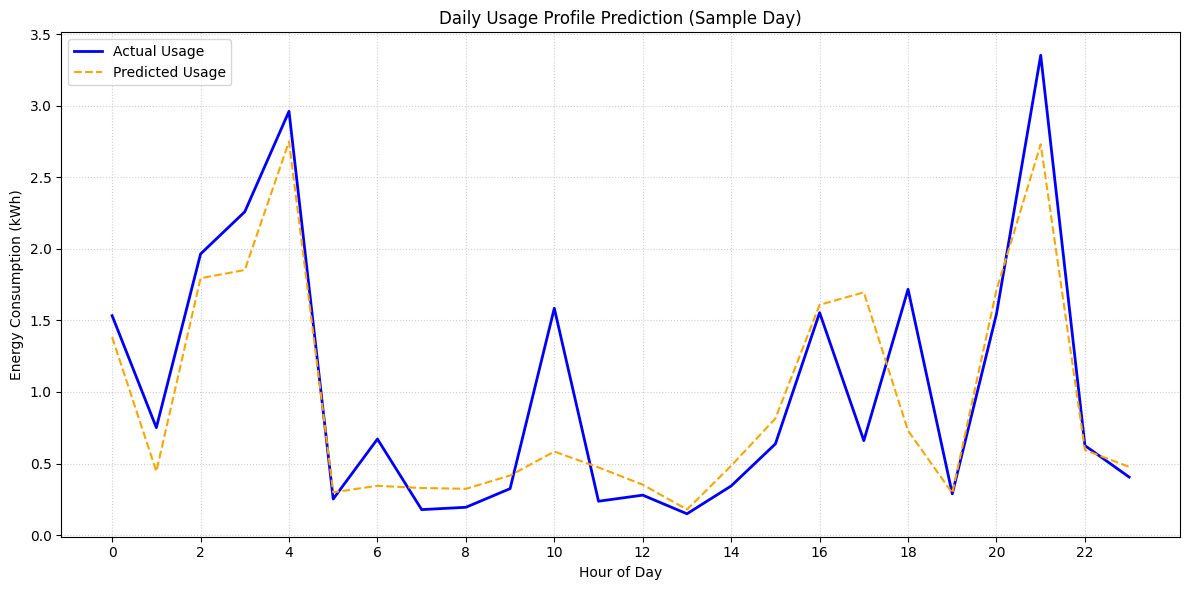

In [99]:
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"MAE: {mae:.2f} kWh")
print(f"R² Score: {r2:.2f}")

# Visualize actual vs predicted for one sample day (24 hours)
day_idx = 0  # first day in the test set
start = day_idx * 24
end = start + 24

actual_day = y_test[start:end]
predicted_day = y_pred[start:end]

plt.figure(figsize=(12, 6))
plt.plot(actual_day, label='Actual Usage', color='blue', linewidth=2)
plt.plot(predicted_day, label='Predicted Usage', color='orange', linestyle='--')
plt.xlabel('Hour of Day')
plt.ylabel('Energy Consumption (kWh)')
plt.title('Daily Usage Profile Prediction (Sample Day)')
plt.xticks(np.arange(0, 24, 2))
plt.legend()
plt.grid(True, linestyle=':', alpha=0.6)
plt.tight_layout()
plt.show()

### Results
Using a RandomForestRegressor model, we predict daily electricity consumption from the past 3 days’ usage and calendar features (weekday, month, weekend). The model explains 66% of the variance (R² = 0.66 ) with a mean absolute error of 0.36 kWh kWh. This demonstrates how ensemble models can capture household routines, supporting smart systems in automating and optimizing energy use based on learned patterns.

## Entertainment/Streaming
### About the dataset:
This dataset includes individual listening sessions from Spotify, capturing track names, play duration (in milliseconds), and timestamps. It allows us to analyze how users interact with music, such as how long they listen and which songs they frequently return to.

In [100]:
df = pd.read_csv('spotify_history.csv')
df.head()

,spotify_track_uri,ts,platform,ms_played,track_name,artist_name,album_name,reason_start,reason_end,shuffle,skipped
0,2J3n32GeLmMjwuAzyhcSNe,2013-07-08 02:44:34,web player,3185,"Say It, Just Say It",The Mowgli's,Waiting For The Dawn,autoplay,clickrow,False,False
1,1oHxIPqJyvAYHy0PVrDU98,2013-07-08 02:45:37,web player,61865,Drinking from the Bottle (feat. Tinie Tempah),Calvin Harris,18 Months,clickrow,clickrow,False,False
2,487OPlneJNni3NWC8SYqhW,2013-07-08 02:50:24,web player,285386,Born To Die,Lana Del Rey,Born To Die - The Paradise Edition,clickrow,unknown,False,False
3,5IyblF777jLZj1vGHG2UD3,2013-07-08 02:52:40,web player,134022,Off To The Races,Lana Del Rey,Born To Die - The Paradise Edition,trackdone,clickrow,False,False
4,0GgAAB0ZMllFhbNc3mAodO,2013-07-08 03:17:52,web player,0,Half Mast,Empire Of The Sun,Walking On A Dream,clickrow,nextbtn,False,False


In [101]:
# Convert timestamp column to datetime
df['timestamp'] = pd.to_datetime(df['ts'], errors='coerce')

# Drop rows with missing essential info
df = df.dropna(subset=['timestamp', 'track_name', 'artist_name', 'ms_played'])

# Filter out listens with zero or very low playtime (e.g., less than 5 seconds)
df = df[df['ms_played'] > 5000]

# Remove duplicates (optional, but safe)
df = df.drop_duplicates()

# Add date and hour columns for aggregation
df['date'] = df['timestamp'].dt.date
df['hour'] = df['timestamp'].dt.hour

print(f"Cleaned data shape: {df.shape}")
df.head()

Cleaned data shape: (104939, 14)


,spotify_track_uri,ts,platform,ms_played,track_name,artist_name,album_name,reason_start,reason_end,shuffle,skipped,timestamp,date,hour
1,1oHxIPqJyvAYHy0PVrDU98,2013-07-08 02:45:37,web player,61865,Drinking from the Bottle (feat. Tinie Tempah),Calvin Harris,18 Months,clickrow,clickrow,False,False,2013-07-08 02:45:37,2013-07-08,2
2,487OPlneJNni3NWC8SYqhW,2013-07-08 02:50:24,web player,285386,Born To Die,Lana Del Rey,Born To Die - The Paradise Edition,clickrow,unknown,False,False,2013-07-08 02:50:24,2013-07-08,2
3,5IyblF777jLZj1vGHG2UD3,2013-07-08 02:52:40,web player,134022,Off To The Races,Lana Del Rey,Born To Die - The Paradise Edition,trackdone,clickrow,False,False,2013-07-08 02:52:40,2013-07-08,2
5,50VNvhzyaSplJCKWchN7a8,2013-07-08 03:17:52,web player,63485,Impossible,James Arthur,Impossible,clickrow,clickrow,False,False,2013-07-08 03:17:52,2013-07-08,3
10,07hII2Rc29q4F2nTE3P1od,2013-07-08 03:20:20,web player,67587,Sun - Gildas Kitsunй Club Night Short Remix,Two Door Cinema Club,The Kitsuné Special Edition #3 (Kitsuné Maison...,clickrow,clickrow,False,False,2013-07-08 03:20:20,2013-07-08,3


In [102]:
# Aggregate listens per day per track
daily_track_stats = df.groupby(['date', 'track_name']).agg(
    total_playtime_ms=('ms_played', 'sum'),
    first_hour=('hour', 'min'),
    listen_count=('ms_played', 'count')
).reset_index()

# Label: "liked" if listened more than once per day
daily_track_stats['liked'] = (daily_track_stats['listen_count'] > 1).astype(int)

# Get artist for each track (from original data)
first_artist = df.groupby('track_name')['artist_name'].first().reset_index()

# Merge artist info
daily_track_stats = daily_track_stats.merge(first_artist, on='track_name', how='left')

# Compute artist popularity (unique tracks per artist)
artist_popularity = df.groupby('artist_name')['track_name'].nunique().reset_index()
artist_popularity.columns = ['artist_name', 'artist_popularity']

daily_track_stats = daily_track_stats.merge(artist_popularity, on='artist_name', how='left')

# Fill any NaNs
daily_track_stats = daily_track_stats.fillna(0)
daily_track_stats.head()

,date,track_name,total_playtime_ms,first_hour,listen_count,liked,artist_name,artist_popularity
0,2013-07-08,7th Street,81893,3,1,0,John Mayer,110
1,2013-07-08,Born To Die,285386,2,1,0,Lana Del Rey,28
2,2013-07-08,Daughters,237896,4,1,0,John Mayer,110
3,2013-07-08,Daughters - Electric Guitar Mix,78943,4,1,0,John Mayer,110
4,2013-07-08,Do I Wanna Know?,95817,3,1,0,Arctic Monkeys,62


In [103]:
# Pivot so rows = days, columns = tracks, values = total playtime
pivot_df = df.pivot_table(index='date', columns='track_name', values='ms_played', aggfunc='sum').fillna(0)

model_nn = NearestNeighbors(n_neighbors=5, metric='cosine')
model_nn.fit(pivot_df.T)

# Apply PCA to reduce dimensionality of track vectors
pca = PCA(n_components=2)
track_vectors_2d = pca.fit_transform(pivot_df.T.values)

# Pick a track, e.g. the most played track overall
most_played_track = pivot_df.sum().idxmax()

# Request 6 neighbors to get the track itself plus 5 others
distances, indices = model_nn.kneighbors(pivot_df.T.loc[[most_played_track]], n_neighbors=6)

# Exclude the first neighbor (it is the track itself)
neighbor_distances = distances[0][1:]
neighbor_indices = indices[0][1:]

print(f"Tracks similar to '{most_played_track}':")
for idx in neighbor_indices:
    print(pivot_df.T.index[idx])

Tracks similar to 'Ode To The Mets':
Bad Decisions
Selfless
Why Are Sundays So Depressing
Not The Same Anymore
Brooklyn Bridge To Chorus


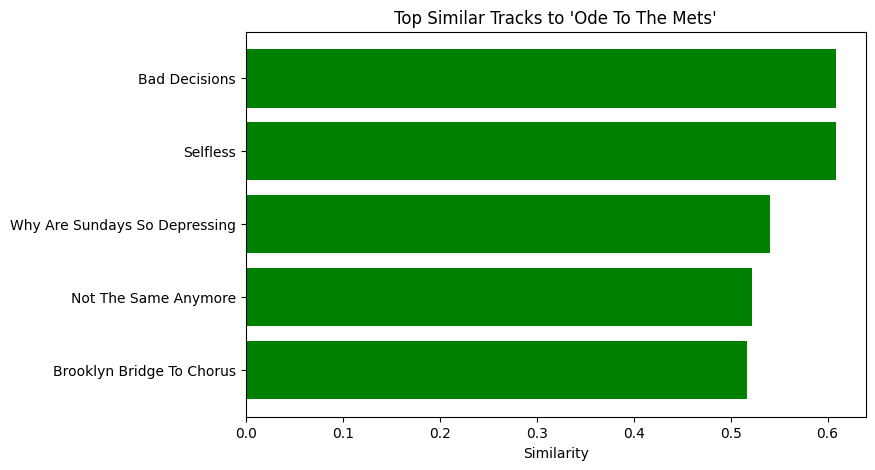

In [105]:
similarities = 1 - neighbor_distances
tracks = [pivot_df.T.index[i] for i in neighbor_indices]

plt.figure(figsize=(8, 5))
plt.barh(tracks, similarities, color='green')
plt.xlabel("Similarity")
plt.title(f"Top Similar Tracks to '{most_played_track}'")
plt.gca().invert_yaxis()
plt.show()

### Results
Using a nearest neighbors model on daily playtime patterns, we can reveal behavioral similarity between tracks. By representing each track as a vector of its daily play durations, we treat listening behavior as a pattern across time. Applyging cosine similarity to these vectors allows us to identify tracks that exhibit similar listening dynamics, enabling recommendations baced on usage patterns

## Gaming/Esports
### About the dataset:
The dataset contains over 41 million cleaned and preprocessed user recommendations (reviews) from a Steam Store. Additionally, it contains detailed information about games and add-ons

In [106]:
df = pd.read_csv("recommendations.csv")
df_sample = df.sample(n=5000, random_state=42)
df.head()

,app_id,helpful,funny,date,is_recommended,hours,user_id,review_id
0,975370,0,0,2022-12-12,True,36.3,51580,0
1,304390,4,0,2017-02-17,False,11.5,2586,1
2,1085660,2,0,2019-11-17,True,336.5,253880,2
3,703080,0,0,2022-09-23,True,27.4,259432,3
4,526870,0,0,2021-01-10,True,7.9,23869,4


In [107]:
# Create user-game matrix (1 if recommended, 0 otherwise)
df_sample['is_recommended'] = df_sample['is_recommended'].astype(int)
user_game = df_sample.pivot_table(index='user_id', columns='app_id', values='is_recommended', fill_value=0)

In [108]:
random_user = np.random.choice(user_game.index)
print(f"Recommending for User ID: {random_user}")

Recommending for User ID: 11008358


In [109]:
user_similarity = cosine_similarity(user_game)
user_similarity_df = pd.DataFrame(user_similarity, index=user_game.index, columns=user_game.index)

In [119]:
# get top 10000 most similar users
similar_users = user_similarity_df[random_user].sort_values(ascending=False)[1:50001]

In [120]:
# # games liked by similar users but not by the original user

user_games = set(user_game.loc[random_user][user_game.loc[random_user] == 1].index)

recommendations = pd.Series(dtype=float)
for sim_user in similar_users.index:
    sim_user_likes = user_game.loc[sim_user]
    recommended_games = sim_user_likes[(sim_user_likes == 1) & (~sim_user_likes.index.isin(user_games))]
    recommendations = recommendations.add(recommended_games, fill_value=0)

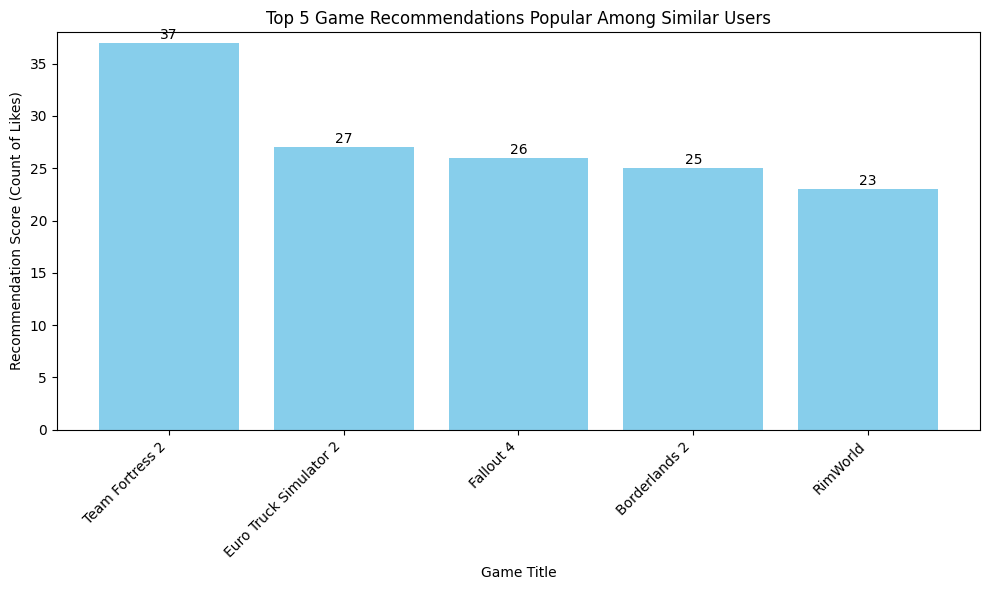

In [121]:
games = pd.read_csv("games.csv")[['app_id', 'title']]

# Sum liked games by similar users
recommendations = user_game.loc[similar_users.index].sum()

# Sort descending and take top 5
top_recommendations = recommendations.sort_values(ascending=False).head(5)

# Convert to DataFrame and merge with titles
top_recommendations_df = pd.DataFrame(top_recommendations).reset_index()
top_recommendations_df.columns = ['app_id', 'score']
top_with_titles = top_recommendations_df.merge(games, on='app_id', how='left')

# Add ranking starting at 1
top_with_titles.insert(0, 'Rank', range(1, len(top_with_titles) + 1))

# Visualization
plt.figure(figsize=(10, 6))
bars = plt.bar(top_with_titles['Rank'], top_with_titles['score'], tick_label=top_with_titles['title'], color='skyblue')
plt.xlabel('Game Title')
plt.ylabel('Recommendation Score (Count of Likes)')
plt.title('Top 5 Game Recommendations Popular Among Similar Users')
plt.xticks(rotation=45, ha='right')
plt.ylim(0, top_with_titles['score'].max() + 1)
plt.tight_layout()

# Add the score label above each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.1, f'{height:.0f}', ha='center', va='bottom')

plt.show()

### Results
Using a user-based collaborative filtering approach, we recommend games liked by similar users. Each user is represented by a binary vector indicating whether a game was recommended to them. Cosine similarity is computed between users to identify behavioral neighbors. For a randomly selected user, we aggregate games liked by the top 1,000 most similar users, excluding those already recommended to the target user. This produces a ranked list of new game suggestions based on community preferences, offering personalized recommendations driven purely by interaction patterns.